In [1]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

ModuleNotFoundError: No module named 'joblib'

In [ ]:
import wandb


In [ ]:
# wandb.login(key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX") # API key


In [ ]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


In [ ]:
CONFIG = {"seed": 2022,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def set_seed(seed=2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [ ]:
def train_test_split(df, train_percent=.85, seed=2022):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [ ]:
Chromium_df = pd.read_csv("Chromium_dataset_clean.csv" , index_col = 0)

# Drop NaN values and reset index of dataframe
Chromium_df = Chromium_df[Chromium_df['text'].notna()]
Chromium_df = Chromium_df.reset_index()
Chromium_df.drop(columns=["index"] , inplace=True)

In [ ]:
TD_df = pd.read_csv("TD_dataset_clean.csv" , index_col = 0)

# Drop NaN values and reset index of dataframe
TD_df = TD_df[TD_df['text'].notna()]
TD_df = TD_df.reset_index()
TD_df.drop(columns=["index"], inplace=True)


In [ ]:
JIRA_df = pd.read_csv("jira_TD_dataset.csv", index_col = 0)

# Drop NaN values and reset index of dataframe
JIRA_df = JIRA_df[JIRA_df['text'].notna()]
JIRA_df = JIRA_df.reset_index()
JIRA_df.drop(columns=["index"], inplace=True)


In [ ]:
TD_df

,text,label
0,we didnt have time to do automated tests or gh...,1
1,user storyas a sre i would like to know that ...,1
2,please explain the process of having a backup ...,0
3,currently the first parse error in a codl docu...,0
4,please use this to only for bug reports for qu...,0
...,...,...
126301,when the adminlogin endpoint is successful an ...,0
126302,we have pretty similar code in scattered acros...,1
126303,is your feature request related to a problem ...,0
126304,batch downloads dont work in safari unless the...,1


In [ ]:
train_td_df , test_td_df = train_test_split(TD_df)

In [ ]:
df = train_td_df

In [ ]:
df.reset_index(inplace = True)

In [ ]:
df.drop(columns=["index"], inplace=True)

In [ ]:
df

,text,label
0,\r\r,1
1,can fix this with maybe,1
2,problem statement\rthe import statements on te...,1
3,describe the bug\rfor token text the match doe...,0
4,update our python projects to the latest versi...,1
...,...,...
107355,issue descriptionfor the list loop component ...,1
107356,im trying to run some js code in goja that con...,0
107357,performance is a feature of vector that we sho...,1
107358,after recent changes the deployment failed on ...,0


In [ ]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [ ]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      0        20157
       1        15630
1      0        19923
       1        15864
2      0        20027
       1        15759
Name: label, dtype: int64

In [ ]:
df

,text,label,kfold
0,\r\r,1,2
1,can fix this with maybe,1,2
2,problem statement\rthe import statements on te...,1,1
3,describe the bug\rfor token text the match doe...,0,1
4,update our python projects to the latest versi...,1,2
...,...,...,...
107355,issue descriptionfor the list loop component ...,1,2
107356,im trying to run some js code in goja that con...,0,1
107357,performance is a feature of vector that we sho...,1,1
107358,after recent changes the deployment failed on ...,0,0


In [ ]:
class TD_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [ ]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [ ]:
class TD_Model(nn.Module):
    def __init__(self, model_name):
        super(TD_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [ ]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [ ]:
def all_classification_report(y_true, y_pred, target_names = ['Non_TD', 'TD'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_TD', 'TD'])
    ax.yaxis.set_ticklabels(['Non_TD', 'TD'])
    
    return  accuracy , f1score
    
    

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [ ]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = TD_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = TD_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [03:09<00:00, 11.82it/s, Epoch=1, LR=9.74e-6, Valid_Loss=0.311]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8767    0.8897    0.8831     20157
          TD     0.8550    0.8386    0.8467     15630

    accuracy                         0.8674     35787
   macro avg     0.8658    0.8641    0.8649     35787
weighted avg     0.8672    0.8674    0.8672     35787

Accuracy = 0.8674
F1_score = 0.8467
Validation Loss Improved (inf ---> 0.31127892274580354)
Model Saved



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:55<00:00, 12.77it/s, Epoch=2, LR=9e-6, Valid_Loss=0.377]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9281    0.7937    0.8556     20157
          TD     0.7758    0.9207    0.8421     15630

    accuracy                         0.8492     35787
   macro avg     0.8520    0.8572    0.8489     35787
weighted avg     0.8616    0.8492    0.8497     35787

Accuracy = 0.8492
F1_score = 0.8421



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:54<00:00, 12.85it/s, Epoch=3, LR=7.86e-6, Valid_Loss=0.297]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8879    0.8955    0.8917     20157
          TD     0.8638    0.8542    0.8589     15630

    accuracy                         0.8775     35787
   macro avg     0.8758    0.8749    0.8753     35787
weighted avg     0.8774    0.8775    0.8774     35787

Accuracy = 0.8775
F1_score = 0.8589
Validation Loss Improved (0.31127892274580354 ---> 0.29675601019642994)
Model Saved

Training complete in 1h 26m 49s
Best Loss: 0.2968


Train Loss,█▄▁
Valid Accuracy,▆▁█
Valid F1_score,▃▁█
Valid Loss,▂█▁
Best Loss,0.29676
Train Loss,0.2406
Valid Accuracy,0.8775
Valid F1_score,0.8589
Valid Loss,0.29676



====== Fold: 1 ======


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:58<00:00, 12.52it/s, Epoch=1, LR=9.74e-6, Valid_Loss=0.32]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8761    0.8714    0.8737     19923
          TD     0.8395    0.8452    0.8423     15864

    accuracy                         0.8598     35787
   macro avg     0.8578    0.8583    0.8580     35787
weighted avg     0.8599    0.8598    0.8598     35787

Accuracy = 0.8598
F1_score = 0.8423
Validation Loss Improved (inf ---> 0.3197778640785191)
Model Saved



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:59<00:00, 12.47it/s, Epoch=2, LR=9e-6, Valid_Loss=0.322]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8936    0.8711    0.8822     19923
          TD     0.8431    0.8697    0.8562     15864

    accuracy                         0.8705     35787
   macro avg     0.8683    0.8704    0.8692     35787
weighted avg     0.8712    0.8705    0.8707     35787

Accuracy = 0.8705
F1_score = 0.8562



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:58<00:00, 12.55it/s, Epoch=3, LR=7.86e-6, Valid_Loss=0.358]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9342    0.7944    0.8586     19923
          TD     0.7826    0.9297    0.8499     15864

    accuracy                         0.8544     35787
   macro avg     0.8584    0.8621    0.8543     35787
weighted avg     0.8670    0.8544    0.8548     35787

Accuracy = 0.8544
F1_score = 0.8499

Training complete in 1h 23m 22s
Best Loss: 0.3198


Train Loss,█▄▁
Valid Accuracy,▃█▁
Valid F1_score,▁█▅
Valid Loss,▁▁█
Best Loss,0.31978
Train Loss,0.24943
Valid Accuracy,0.8544
Valid F1_score,0.8499
Valid Loss,0.35802



====== Fold: 2 ======


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:53<00:00, 12.91it/s, Epoch=1, LR=9.74e-6, Valid_Loss=0.348]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9173    0.7973    0.8531     20027
          TD     0.7792    0.9087    0.8389     15759

    accuracy                         0.8464     35786
   macro avg     0.8482    0.8530    0.8460     35786
weighted avg     0.8565    0.8464    0.8469     35786

Accuracy = 0.8464
F1_score = 0.8389
Validation Loss Improved (inf ---> 0.3484930349243751)
Model Saved



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:55<00:00, 12.76it/s, Epoch=2, LR=9e-6, Valid_Loss=0.318]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9202    0.8186    0.8664     20027
          TD     0.7978    0.9098    0.8501     15759

    accuracy                         0.8587     35786
   macro avg     0.8590    0.8642    0.8583     35786
weighted avg     0.8663    0.8587    0.8592     35786

Accuracy = 0.8587
F1_score = 0.8501
Validation Loss Improved (0.3484930349243751 ---> 0.318192101371686)
Model Saved



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:53<00:00, 12.86it/s, Epoch=3, LR=7.86e-6, Valid_Loss=0.316]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8525    0.9261    0.8878     20027
          TD     0.8946    0.7964    0.8427     15759

    accuracy                         0.8690     35786
   macro avg     0.8736    0.8613    0.8652     35786
weighted avg     0.8711    0.8690    0.8679     35786

Accuracy = 0.869
F1_score = 0.8427
Validation Loss Improved (0.318192101371686 ---> 0.3164748893229896)
Model Saved

Training complete in 1h 23m 43s
Best Loss: 0.3165


Train Loss,█▄▁
Valid Accuracy,▁▅█
Valid F1_score,▁█▃
Valid Loss,█▁▁
Best Loss,0.31647
Train Loss,0.23694
Valid Accuracy,0.869
Valid F1_score,0.8427
Valid Loss,0.31647


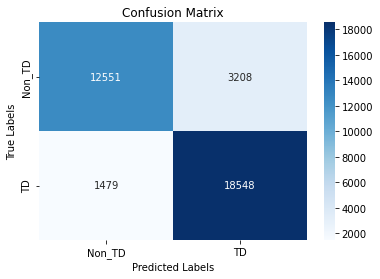

In [ ]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='TD_Paper_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = TD_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [ ]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [ ]:
test_df = test_td_df

In [ ]:
test_df

,text,label
116263,some logic has been extracted into lsifprotoco...,1
73271,music less than half no music at all in the ...,0
92484,egui on macos with winit wgpu backend\r\rim...,0
58196,pleaes update jenkins file with hello,0
23702,cloned from,1
...,...,...
46769,please\r\r check for duplicate issues\r prov...,0
103024,what happenedissue template featurerequestyml...,0
16557,a user is unable to delete or remove their soc...,0
1244,recovering user account,0


In [ ]:
class TD_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = TD_Model(CONFIG['model_name'])

In [ ]:
def prepare_test_loader(test_df):    
    test_dataset = TD_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [ ]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [ ]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1185/1185 [01:30<00:00, 13.10it/s]


Fold 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1185/1185 [01:30<00:00, 13.08it/s]


Fold 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1185/1185 [01:30<00:00, 13.16it/s]


In [ ]:
deberta_predictions


[array([[0.00249016, 0.99750984],
        [0.9337457 , 0.06625428],
        [0.9768282 , 0.02317182],
        ...,
        [0.9869091 , 0.01309085],
        [0.98892945, 0.01107053],
        [0.708971  , 0.29102904]], dtype=float32),
 array([[0.05083668, 0.9491634 ],
        [0.86991763, 0.13008237],
        [0.9852502 , 0.01474987],
        ...,
        [0.96862876, 0.03137123],
        [0.91843826, 0.08156181],
        [0.489111  , 0.510889  ]], dtype=float32),
 array([[0.00574924, 0.9942508 ],
        [0.9817416 , 0.01825844],
        [0.9870652 , 0.01293482],
        ...,
        [0.99535674, 0.00464319],
        [0.96975434, 0.03024564],
        [0.78687465, 0.21312535]], dtype=float32)]

In [ ]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.01969203, 0.980308  ],
       [0.9284683 , 0.0715317 ],
       [0.9830478 , 0.01695217],
       ...,
       [0.98363155, 0.01636842],
       [0.95904064, 0.04095932],
       [0.6616522 , 0.3383478 ]], dtype=float32)

In [ ]:
len(predictions)

18946

In [ ]:
predictions

array([[0.01969203, 0.980308  ],
       [0.9284683 , 0.0715317 ],
       [0.9830478 , 0.01695217],
       ...,
       [0.98363155, 0.01636842],
       [0.95904064, 0.04095932],
       [0.6616522 , 0.3383478 ]], dtype=float32)

In [ ]:
test_df["prediction_0"] = predictions[:, 0] 

In [ ]:
test_df["prediction_1"] = predictions[:, 1] 

In [ ]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [ ]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
116263,some logic has been extracted into lsifprotoco...,1,0.019692,0.980308,1,1,1
73271,music less than half no music at all in the ...,0,0.928468,0.071532,0,0,0
92484,egui on macos with winit wgpu backend\r\rim...,0,0.983048,0.016952,0,0,0
58196,pleaes update jenkins file with hello,0,0.333593,0.666407,1,0,1
23702,cloned from,1,0.186655,0.813345,1,1,1
...,...,...,...,...,...,...,...
46769,please\r\r check for duplicate issues\r prov...,0,0.996333,0.003667,0,0,0
103024,what happenedissue template featurerequestyml...,0,0.998019,0.001981,0,0,0
16557,a user is unable to delete or remove their soc...,0,0.983632,0.016368,0,0,0
1244,recovering user account,0,0.959041,0.040959,0,0,0


In [ ]:
len(test_df)

18946

In [ ]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [ ]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [ ]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [ ]:
test_df["pred"] = test_df["pred"].astype(int)

In [ ]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
116263,some logic has been extracted into lsifprotoco...,1,0.019692,0.980308,1,1,1,prediction_1,1
73271,music less than half no music at all in the ...,0,0.928468,0.071532,0,0,0,prediction_0,0
92484,egui on macos with winit wgpu backend\r\rim...,0,0.983048,0.016952,0,0,0,prediction_0,0
58196,pleaes update jenkins file with hello,0,0.333593,0.666407,1,0,1,prediction_1,1
23702,cloned from,1,0.186655,0.813345,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
46769,please\r\r check for duplicate issues\r prov...,0,0.996333,0.003667,0,0,0,prediction_0,0
103024,what happenedissue template featurerequestyml...,0,0.998019,0.001981,0,0,0,prediction_0,0
16557,a user is unable to delete or remove their soc...,0,0.983632,0.016368,0,0,0,prediction_0,0
1244,recovering user account,0,0.959041,0.040959,0,0,0,prediction_0,0


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[9604  951]
 [1248 7143]]


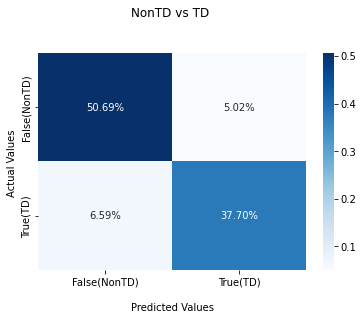

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonTD vs TD \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonTD)','True(TD)'])
ax.yaxis.set_ticklabels(['False(NonTD)','True(TD)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     10555
           1       0.88      0.85      0.87      8391

    accuracy                           0.88     18946
   macro avg       0.88      0.88      0.88     18946
weighted avg       0.88      0.88      0.88     18946

